# Four ways to conduct one-way ANOVAs with Python

https://www.marsja.se/four-ways-to-conduct-one-way-anovas-using-python/#anovapy

In the four examples in this tutorial we are going to use the dataset “PlantGrowth” that originally was available in R but can be downloaded using this link: [PlantGrowth](https://vincentarelbundock.github.io/Rdatasets/csv/datasets/PlantGrowth.csv). In the first three examples we are going to use Pandas DataFrame.

In [4]:
%matplotlib inline

import pandas as pd


plant_growth = pd.read_csv("datasets/PlantGrowth.csv")

In [2]:
plant_growth.head()

,Unnamed: 0,weight,group
0,1,4.17,ctrl
1,2,5.58,ctrl
2,3,5.18,ctrl
3,4,6.11,ctrl
4,5,4.50,ctrl


In [9]:
ctrl = plant_growth['weight'][plant_growth.group == 'ctrl']

grps = pd.unique(plant_growth.group.values)
d_plant_growth = {grp:plant_growth['weight'][plant_growth.group == grp] for grp in grps}

k = len(pd.unique(plant_growth.group))  # number of conditions
N = len(plant_growth.values)  # conditions times participants
n = plant_growth.groupby('group').size()[0] #Participants in each condition

In [11]:
d_plant_growth

{'ctrl': 0    4.17
 1    5.58
 2    5.18
 3    6.11
 4    4.50
 5    4.61
 6    5.17
 7    4.53
 8    5.33
 9    5.14
 Name: weight, dtype: float64, 'trt1': 10    4.81
 11    4.17
 12    4.41
 13    3.59
 14    5.87
 15    3.83
 16    6.03
 17    4.89
 18    4.32
 19    4.69
 Name: weight, dtype: float64, 'trt2': 20    6.31
 21    5.12
 22    5.54
 23    5.50
 24    5.37
 25    5.29
 26    4.92
 27    6.15
 28    5.80
 29    5.26
 Name: weight, dtype: float64}

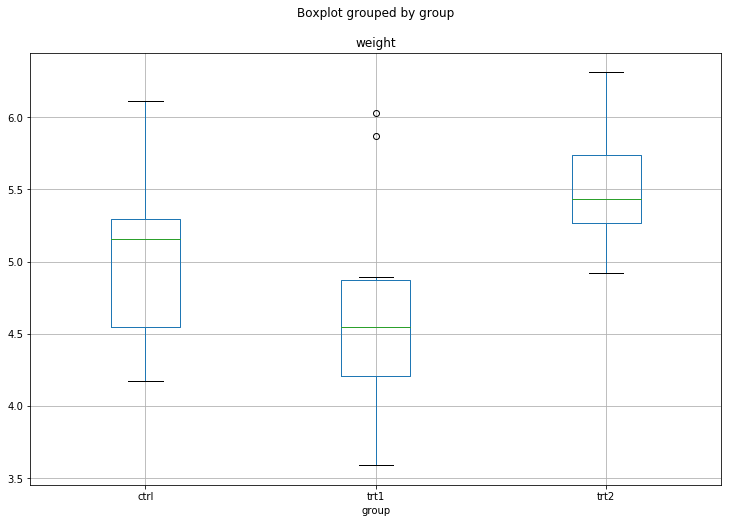

In [5]:
plant_growth.boxplot("weight", by="group", figsize=(12, 8))

## Using SciPy

We start with using SciPy and its method f_oneway from stats.

In [12]:
from scipy import stats

stats.f_oneway(d_plant_growth["ctrl"], d_plant_growth["trt1"], d_plant_growth["trt2"])

F_onewayResult(statistic=4.846087862380136, pvalue=0.015909958325622899)

One problem with using SciPy is that  following APA guidelines we should also effect size (e.g., eta squared) as well as Degree of freedom (DF). DFs needed for the example data is easily obtained.

In [13]:
DFbetween = k - 1
DFwithin = N - k
DFtotal = N - 1

However, if we want to calculate eta-squared we need to do some more computations. Thus, the next section will deal with how to calculate a one-way ANOVA using the Pandas DataFrame and Python code.

## Using Python

A one-way ANOVA is quite easy to calculate so below I am going to show how to do it. First, we need  to calculate the sum of squares between (SSbetween), sum of squares within (SSwithin), and sum of squares total (SSTotal).

### Sum of Squares Between

We start with calculating the Sum of Squares between. Sum of Squares Between is the variability due to interaction between the groups. Sometimes known as the Sum of Squares of the Model.

![SSbetween](resources/four_ways_1.png "SSbetween")

In [17]:
SSbetween = (sum(plant_growth.groupby('group').sum()['weight']**2)/n) \
             - (plant_growth['weight'].sum()**2)/N

### Sum of Squares Within

The variability in the data due to differences within people. The calculation of Sum of Squares Within can be carried out according to this formula.

![SSwithin](resources/four_ways_2.png "SSwithin")

In [20]:
sum_y_squared = sum([value**2 for value in plant_growth['weight'].values])
SSwithin = sum_y_squared - sum(plant_growth.groupby('group').sum()['weight']**2)/n

### Sum of Squares Total

Sum of Squares Total will be needed to calculate eta-squared later. This is the total variability in the data.

![SStotal](resources/four_ways_3.png "SStotal")


In [22]:
SStotal = sum_y_squared - (plant_growth['weight'].sum()**2)/N

### Mean Square Between

Mean square between is the sum of squares within divided by degree of freedom between.

In [23]:
MSbetween = SSbetween / DFbetween

### Mean Square Within

Mean Square within is also an easy calculation.

In [25]:
MSwithin = SSwithin / DFwithin

### Calculating the F-value

In [26]:
F = MSbetween / MSwithin
F

4.8460878623796795

To reject the null hypothesis we check if the obtained F-value is above the critical value for rejecting the null hypothesis. We could look it up in a F-value table based on the DFwithin and DFbetween. However, there is a method in SciPy for obtaining a p-value.

In [28]:
p = stats.f.sf(F, DFbetween, DFwithin)
p

0.015909958325628245

Finally, we are also going to calculate effect size. We start with the commonly used eta-squared (η² ).

In [29]:
eta_sqrd = SSbetween / SStotal

However, eta-squared is somewhat biased because it is based purely on sums of squares from the sample. No adjustment is made for the fact that what we aiming to do is to estimate the effect size in the population. Thus, we can use the less biased effect size measure Omega squared.

In [30]:
om_sqrd = (SSbetween - (DFbetween * MSwithin))/(SStotal + MSwithin)

The results we get from both the SciPy and the above method can be reported according to APA style; F(2, 27) = 4.846, p =  .016, η² =  .264. If you want to report Omega Squared: ω2 = .204

## Using Statsmodels

The third method, using Statsmodels, is also easy. We start by using ordinary least squares method and then the anova_lm method. Also, if you are familiar with R-syntax. Statsmodels have a formula api where your model is very intuitively formulated. First, we import the api and the formula api. Second we, use ordinary least squares regression with our data. The object obtained is a fitted model that we later use with the anova_lm method to obtaine a ANOVA table.

In [31]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

model = ols("weight ~ group", data=plant_growth).fit()

In [32]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 weight   R-squared:                       0.264
Model:                            OLS   Adj. R-squared:                  0.210
Method:                 Least Squares   F-statistic:                     4.846
Date:                Fri, 05 Jan 2018   Prob (F-statistic):             0.0159
Time:                        16:32:32   Log-Likelihood:                -26.810
No. Observations:                  30   AIC:                             59.62
Df Residuals:                      27   BIC:                             63.82
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
Intercept         5.0320      0.197     25.527      0.000         4.628     5.436
group[T.trt1]    -0.3710      0.279     -1.331      0.194        -0.943     0.201
group[T.trt2]     0.4940      0.279      1.772      0.088        -0.078     1.066
==============================================================================
Omnibus:                        1.835   Durbin-Watson:                   2.704
Prob(Omnibus):                  0.400   Jarque-Bera (JB):                1.406
Skew:                           0.524   Prob(JB):                        0.495
Kurtosis:                       2.835   Cond. No.                         3.73
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [36]:
aov_table = sm.stats.anova_lm(model, typ=2)
aov_table

,sum_sq,df,F,PR(>F)
group,3.76634,2.0,4.846088,0.01591
Residual,10.49209,27.0,NaN,NaN


As can be seen in the ANVOA table Statsmodels don’t provide an effect size .  To calculate eta squared we can use the sum of squares from the table.

In [38]:
esq_sm = aov_table['sum_sq'][0]/(aov_table['sum_sq'][0]+aov_table['sum_sq'][1])
esq_sm

0.2641482968321196